# Biot-Savart Law For an Infinitesimally Thin Vortex

$$
\vec u (\vec r) = \frac{\Gamma}{4 \pi} \oint_{\vec C} \frac{\hat t \times \vec \xi} {\| \vec \xi \|^2} d \ell
$$

where
- $\vec r$: the point in the field where the velocity due to the vortex is being evaluated
- $\Gamma$: circulation (or *vortex strength*)
- $\vec C(\ell)$: curve defining vortex and parameterized by its arclength $\ell$
- $\hat t$: unit vector tangent to the curve $C$
- $\vec \xi (\ell)$ = $\vec r - \vec C(\ell)$

## Numerical Line Integral (order 0)

**Trapezoidal rule**

Given the definite integral
$$
I = \int_a^b f(x) dx
$$

The (non-uniform chained) trapezoidal rule approximates the region under the curve $f(x)$ as a series of trapezoids. The area of each trapezoid is
$$
A_i = \frac{1}{2} (x_{i+1} - x_i) (f(x_{i+1}) + f(x_i))
$$
where $x_i = a + i \Delta x$ and $\Delta x = \frac{b-a}{N}$ (or a list of $x$ values which may be non-uniform can be provided). The total area is the sum of the areas of each trapezoid
$$
I \approx \sum_{i=0}^{N-1} A_i = \frac{1}{2} \sum_{i=0}^{N-1} (x_{i+1} - x_i) (f(x_{i+1}) + f(x_i))
$$

When the $x$ values are uniformly spaced, the trapezoidal rule is equivalent to the composite midpoint rule?
$$
I \approx \Delta x \left( \frac{1}{2}(f(x_0) + f(x_1)) + \sum_{i=1}^{N-1} f(x_i) \right)
$$

> [!Note]
> 
> This is a basic numerical integration method. It should have low accuracy. This should be replaced by a higher order method (either from a library or a custom implementation). Examples of higher order methods include Simpson's rule, Gaussian quadrature, etc.

**Steps**
- The user specifies a position $\vec r$ (where the velocity $\vec u$ is evaluated), the circulation $\Gamma$, the path of the vortex $C$, and  an integration step size $\Delta \ell$.
- The path $C$ is a set of points connected by straight lines. $\hat t$ can be computed using the points in $C$. The straight line segments are then subdivide into $N = \frac{|\vec C_{i+1} - \vec C_i|}{\Delta \ell}$ segments.
- $\ell_i$, $\hat t_i$, $C_i$, $\xi_i$ are evaluated for $i \in [0, N]$
- the trapzoidal rule is evaluated.
- The result is multiplied by $\frac{\Gamma}{4 \pi}$ and returned

In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# # Playing with diff
# 
# a = np.arange(15).reshape(-1, 3)
# print('a =\n', a)
# 
# diff = np.diff(a, axis=0)
# print('diff =\n' , diff)


In [40]:
# This is a low accuracy implementation of the Biot-Savart law
# for an infinitesimally thin vortex (i.e., this is missing 
# core size!)
def bs_vel_trap(r, Gamma, C, step_size):
    '''
    Parameters:
        - r: numpy array of shape (3,) representing the position where the velocity is evaluated.
        - Gamma: numpy array of shape (3,) representing the circulation of the vortex at each point in C.
        - C: numpy array of shape (N, 3) where N is the number of points in the curve.
        - Dell: float representing the integration step size.
        
    Returns:
        - u: numpy array of shape (3,) representing the velocity at r due to the vortex.
    '''
    # print('r.shape =', r.shape)
    # print('Gamma.shape =', Gamma.shape)
    # print('C.shape =', C.shape)
    # print('step_size =', step_size)
    
    # # compute the tangent vectors
    # t = np.diff(C, axis=0)
    
    ustep = []
    # Loop through each segment of the curve
    for i in range(len(C)-1):
        t = C[i+1] - C[i]
        that = t / np.linalg.norm(t)
        N = int(np.linalg.norm(t) / step_size)
        Csteps, Dell_vec = np.linspace(C[i], C[i+1], N, retstep=True)
        Dell = np.linalg.norm(Dell_vec)
        # print('(DEBUG) that =', that)
        # print('(DEBUG) N =', N)
        # print('(DEBUG) Csteps.shape =', Csteps.shape)
        # print('(DEBUG) Dell_vec =', Dell_vec)
        # print('(DEBUG) Dell =', Dell)
        
        # Numerical integral using the trapezoidal rule
        integrand = []
        for ii in range(N):
            xi = r - Csteps[ii]
            integrand.append(np.cross(that, xi) / np.linalg.norm(xi)**2)
        trap_integrand = (0.5 * (integrand[0] + integrand[-1]) + np.sum(integrand[1:-1], axis=0)) * Dell
        
        ustep.append(trap_integrand)
        
    u = np.sum(ustep, axis=0) * Gamma / (4 * np.pi)
    return u

def vec_bs_vel_trap(r, Gamma, C, step_size):
    try:
        len(r)  # can you get the length of r?
        r[0]  # can you index r?
    except TypeError:
        # If no to any of the above, assume r is a scalar
        # and use the function directly
        return bs_vel_trap(r, Gamma, C, step_size)
    else:
        # If yes to both of the above, assume r is an array
        # and loop over all the elements of r
        u_vec = []
        for r_i in r:
            u_vec.append(bs_vel_trap(r_i, Gamma, C, step_size))
        
        return np.array(u_vec)
    

In [41]:
# Validate the function against the analytical solution for a straight line vortex

def straight_line_vortex(cs, length, Nv, max_val_s, Ns, Gamma):
    '''
    Make a straight line vortex aligned with the x-axis, of length `length` with `Nv` points, core size `cs`, and circulation `Gamma`. Return the magnitude of the velocity evaluated along the y-axis out to `max_val_s` with `Ns` points, and the vortex.
    
    Parameters:
        - cs: float representing the radius of the vortex core.
        - length: float representing the length of the vortex.
        - Nv: int representing the number of points in the vortex.
        - max_val_s: float representing the maximum distance s from the vortex core that the velocity is evaluated.
        - Ns: int representing the number of points where the velocity is evaluated.
        - Gamma: float representing the circulation of the vortex.
    
    Returns:
        - umag_vec: numpy array of shape (Ns,) representing the magnitude of the velocity.
        - r_vec: numpy array of shape (Ns, 3) representing the positions where the velocity is evaluated.
        - Gamma_vec: numpy array of shape (N, 3) representing the circulation of the vortex at each point in C.
        - C: numpy array of shape (N, 3) representing the curve of the vortex.
    '''
    # s cannot be equal to 0 because the 1 / s term in the analytical
    # solution blows up. To avoid this, we start s 1e-9 (which is basically 0).
    s_vec, ds = np.linspace(1e-9, max_val_s, Ns, retstep=True)
    Cx_vec, dCx = np.linspace(-length/2, length/2, Nv, retstep=True)
    # print('Cx_vec =', Cx_vec)
    
    umagz_vec = Gamma * (1 - np.exp(0.5 * -s_vec**2 / cs ** 2)) / (2 * np.pi * s_vec)
    umag_vec = np.zeros((Ns, 3))
    umag_vec[:, 2] = umagz_vec
    
    r_vec = np.zeros((Ns, 3))
    r_vec[:, 1] = s_vec
    
    C = np.zeros((Nv, 3))
    C[:, 0] = Cx_vec
    
    Gamma_vec = np.ones(Nv) * Gamma
    
    print('ds =', ds)
    print('dCx =', dCx)
    
    return umag_vec, (r_vec, Gamma_vec, C)

ds = 2.222222222111111
dCx = 100.0
u_vec_true.shape = (10, 3)
vrtx[0][0, 1] = 1e-09
(DEBUG) that = [1. 0. 0.]
(DEBUG) N = 100
(DEBUG) Csteps.shape = (100, 3)
(DEBUG) Dell_vec = [1.01010101 0.         0.        ]
(DEBUG) Dell = 1.0101010101010102
integrand[0] + integrand[-1] = [0.e+00 0.e+00 1.e+09]
np.sum(integrand[1:-1], axis=0) = [0.00000000e+00 0.00000000e+00 1.60224971e-09]
trap_integrand =
 [0.00000000e+00 0.00000000e+00 5.05050505e+08]
(DEBUG) that = [1. 0. 0.]
(DEBUG) N = 100
(DEBUG) Csteps.shape = (100, 3)
(DEBUG) Dell_vec = [1.01010101 0.         0.        ]
(DEBUG) Dell = 1.0101010101010102
integrand[0] + integrand[-1] = [0.e+00 0.e+00 1.e+09]
np.sum(integrand[1:-1], axis=0) = [0.00000000e+00 0.00000000e+00 1.60224971e-09]
trap_integrand =
 [0.00000000e+00 0.00000000e+00 5.05050505e+08]
(DEBUG) that = [1. 0. 0.]
(DEBUG) N = 100
(DEBUG) Csteps.shape = (100, 3)
(DEBUG) Dell_vec = [1.01010101 0.         0.        ]
(DEBUG) Dell = 1.0101010101010102
integrand[0] + integrand[-1] =

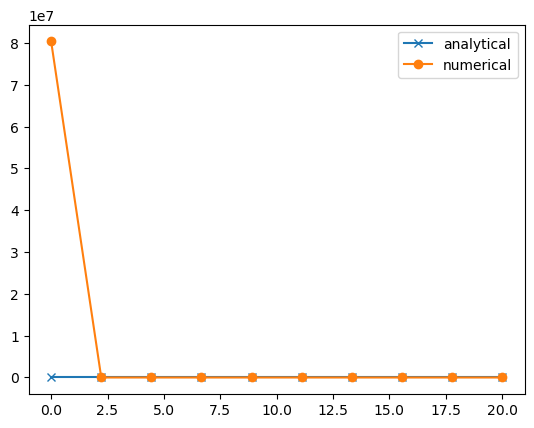

In [48]:
u_vec_true, vrtx = straight_line_vortex(cs=4,
                                        length=200,
                                        Nv=3,
                                        max_val_s=20,
                                        Ns=10,
                                        Gamma=1.0)
print('u_vec_true.shape =', u_vec_true.shape)
print('vrtx[0][0, 1] =', vrtx[0][0, 1])

u_vec_num = vec_bs_vel_trap(*vrtx, 1.0)
print('u_vec_num.shape =', u_vec_num.shape)
print('u_vec_num =\n', u_vec_num)

plt.plot(vrtx[0][:, 1], u_vec_true[:, 2], 'x-', label='analytical')
plt.plot(vrtx[0][:, 1], u_vec_num[:, 2], 'o-', label='numerical')
plt.legend()
plt.show()